Code referenced from https://www.youtube.com/watch?v=CbTU92pbDKw

In [ ]:
from helpers import *
from preprocessor import *

df = html_get_df("MSFT RAW.html")

df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
9926,1986-03-13,0.09,0.1,0.09,0.1,0.06,1031788800
9925,1986-03-14,0.10,0.1,0.10,0.1,0.06,308160000
9924,1986-03-17,0.10,0.1,0.10,0.1,0.06,133171200
9923,1986-03-18,0.10,0.1,0.10,0.1,0.06,67766400
9922,1986-03-19,0.10,0.1,0.10,0.1,0.06,47894400


In [37]:
df = df[['Date', 'Close']]
df.index = df.pop('Date') # set date as the index instead of numbering
df

,Close
Date,
1986-03-13,0.10
1986-03-14,0.10
1986-03-17,0.10
1986-03-18,0.10
1986-03-19,0.10
...,...
2025-07-31,533.50
2025-08-01,524.11
2025-08-04,535.64


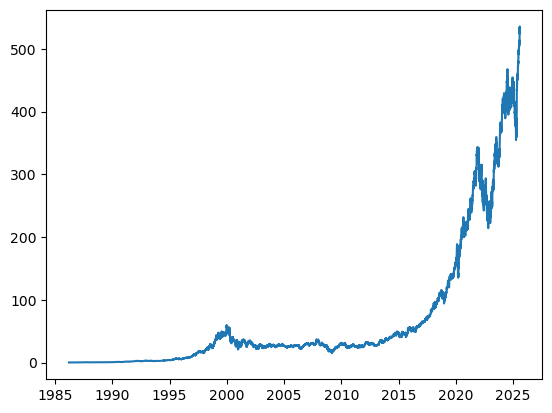

In [38]:
import matplotlib.pyplot as plt
plt.plot(df)

In [39]:
# Start day second time around: '2021-03-25'
windowed_df = df_to_windowed_df(df, 
                                '2021-03-25', 
                                '2022-03-23', 
                                n=3)
windowed_df

# target 1-3 are previous n values. This converts the inputs to the target output.

,Target Date,Target-3,Target-2,Target-1,Target
0,2021-03-25,235.99,237.58,235.46,232.34
1,2021-03-26,237.58,235.46,232.34,236.48
2,2021-03-29,235.46,232.34,236.48,235.24
3,2021-03-30,232.34,236.48,235.24,231.85
4,2021-03-31,236.48,235.24,231.85,235.77
...,...,...,...,...,...
247,2022-03-17,276.44,287.15,294.39,295.22
248,2022-03-18,287.15,294.39,295.22,300.43
249,2022-03-21,294.39,295.22,300.43,299.16
250,2022-03-22,295.22,300.43,299.16,304.06


In [40]:
dates, X, y = windowed_df_to_date_X_y(windowed_df)

dates.shape, X.shape, y.shape

((252,), (252, 3, 1), (252,))

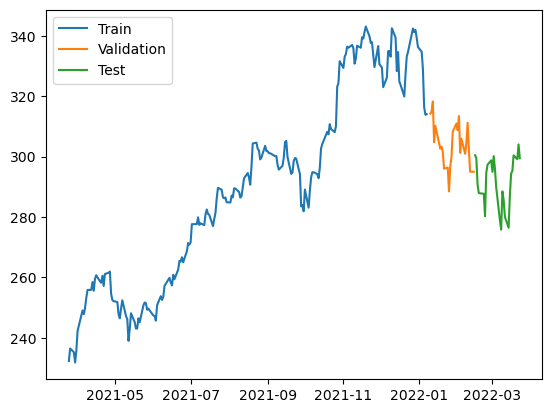

In [41]:
q_80 = int(len(dates) * 0.8)
q_90 = int(len(dates) * 0.9)

dates_train, X_train, y_train = dates[:q_80], X[:q_80], y[:q_80]

dates_val, X_val, y_val = dates[q_80:q_90], X[q_80:q_90], y[q_80:q_90]
dates_test, X_test, y_test = dates[q_90:], X[q_90:], y[q_90:]

plt.plot(dates_train, y_train)
plt.plot(dates_val, y_val)
plt.plot(dates_test, y_test)

plt.legend(['Train', 'Validation', 'Test'])

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

model = Sequential([layers.Input((3, 1)), # 3 days in the past input shape
                    layers.LSTM(64),
                    layers.Dense(32, activation='swish'),
                    layers.Dense(32, activation='swish'),
                    layers.Dense(1)])

model.compile(loss='mse', 
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100)


Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 85567.6016 - mean_absolute_error: 290.7423 - val_loss: 92484.3203 - val_mean_absolute_error: 304.0253
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 83003.6094 - mean_absolute_error: 286.3282 - val_loss: 92185.0000 - val_mean_absolute_error: 303.5326
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 84432.1875 - mean_absolute_error: 288.7864 - val_loss: 91890.9766 - val_mean_absolute_error: 303.0479
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 82943.3047 - mean_absolute_error: 286.3492 - val_loss: 91566.3672 - val_mean_absolute_error: 302.5118
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 83760.6016 - mean_absolute_error: 287.6524 - val_loss: 91140.7578 - val_mean_absolute_error: 301.8075
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 83994.9688 - mean_absolute_error: 288.2126 - val_loss: 90535.7812 - val_mean_absolute_error: 300.8035
Epoch 7/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/s

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


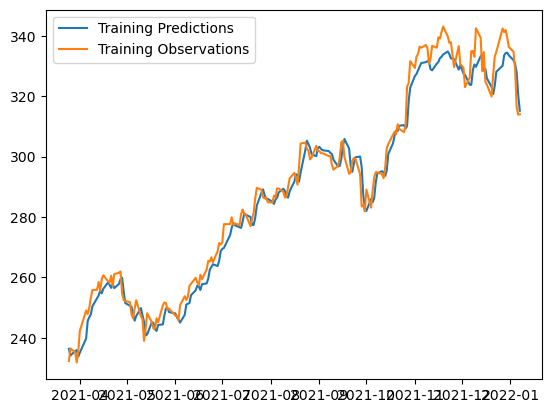

In [52]:
train_predictions = model.predict(X_train).flatten()

plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.legend(['Training Predictions', 'Training Observations'])

Recall that we use a prev 3 day to predict current point. This is characteristics of a lagging controller. This is shown in the plots where the predictions lag behind the actual value. 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


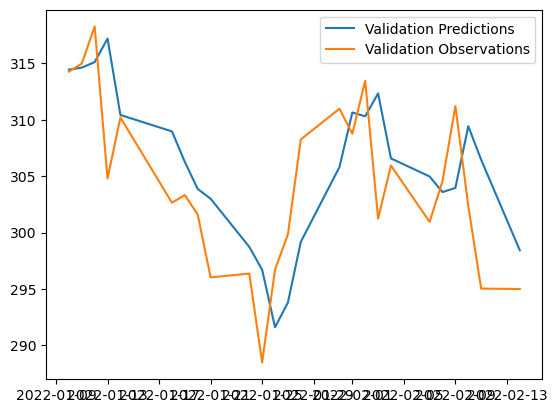

In [53]:
val_predictions = model.predict(X_val).flatten()

plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.legend(['Validation Predictions', 'Validation Observations'])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


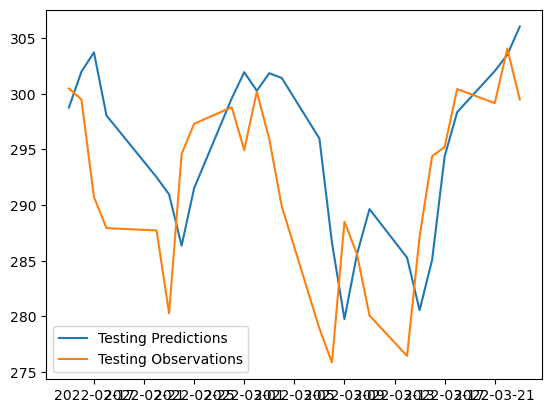

In [50]:
test_predictions = model.predict(X_test).flatten()

plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Testing Predictions', 'Testing Observations'])

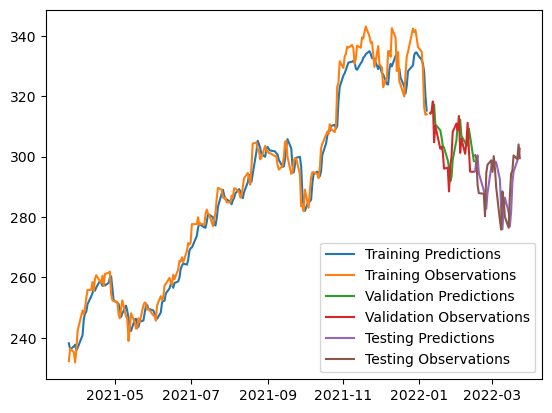

In [46]:
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Training Predictions', 
            'Training Observations',
            'Validation Predictions', 
            'Validation Observations',
            'Testing Predictions', 
            'Testing Observations'])